In [1]:
#%matplotlib notebook

from numpy import sort as srt,cov,bitwise_or,array,corrcoef


from sklearn.ensemble import RandomForestRegressor
max_depth=10

from seaborn import pairplot





# Random scores and their losses for binary classification
- Work with randomly distributed feature and target data $(x,y)$ taking values in $\in\mathcal X\times\mathcal Y$, want to be able to theoretically justify a prediction $\hat y$ we make for $y$
- Classification is the case where $\mathcal Y$ is a finite set $\#\mathcal Y=N_{\texttt{lab}}<\infty$ of possible target label values - statistics about such models take discrete values but the random setting means that objectives can be related in a natural way to continuous valued functions

### Possible scores for a single prediction
- Feature and target data $(x,y)$ taking values in $\mathcal X\times\mathcal Y$, want to be able to theoretically justify a prediction $\hat y$ for $y$
- Generallity allow predictions to depend on varying costs of misclassifications
- To compute some statistic $c$ about a classification a user first has to fix some function of the possible prediction and outcomes $(\hat y,y)\in\mathcal Y^2$
- For classification any such function can be represented by its values on the $N^2$ possible outcomes so that $c=C_s(\hat y,y)$ where $s$ is an RV taking values in a finite dimensional space of parameters $\Sigma$
- Assuming a misclassification is always worse than a correct classification, we can rescale by eg subtracting any profits that would be gained from a correct prediction and restrict to an $N^2-N$ dimensional family of misclassification costs
- For binary classification $N=2$ this means that up to a rescaling there are only two degrees of freedom for possible prediction-outcome pairs and the random statistic can be written
$$
c=C_\sigma(\hat y,y)
$$
where $\sigma_-=C_\sigma(+,-)$ and $\sigma_+=C_\sigma(-,+)$ are the costs of a false positive and false positive respectively
- For fixed sampled value of $\sigma$ can write down a Bayes rule in terms of the marginals
$$
y^*(x',\sigma)=\begin{cases}+\text{ if }\rho(x')=\frac{\mathbb P(+|x=x')}{\mathbb P(-|x=x')}>\frac{\sigma_+}{\sigma_-},\\-\text{ otherwise}\end{cases}
$$
- This means that for a fixed $\kappa=\frac{\sigma_+}{\sigma_-}$ the optimal solution just checks whether the relative likelihood is greater than $\kappa$

# First experiments
First dataset to work with is cybersecurity: UNSW-NB15

In [2]:
from cal.dl import unsw
#data_unscaled=unsw(lab_cat=True,rescale=False)
data_rescaled=unsw(lab_cat=True,rescale=True)

- Depending on experimental procedure, need to split data etc, here: train-test split

In [3]:
(x_train,all_classes_train),(x_test,all_classes_test),(df_train,df_test),sc=data_rescaled


- First consider boring case where $\sigma$ is constant
- Rescaling $C$ by a constant doesn't change problem, can parameterise by a single number eg common choice $\beta^2=\frac{\sigma_-}{\sigma_+}$ or similar
- Can write expected cost for fixed feature $x=x'$ and prediction $\hat y=y'$ which we wish to minimise in expectation
$$
\mathbb E(C(y,y')|x=x')=\sigma_{-y'}\mathbb P(y=-y'|x=x')
$$

This has multiple classes, focus on one class for now:

In [4]:
y_train,y_test=all_classes_train=='Generic',all_classes_test=='Generic'

In [5]:
from cal.jal import shuffle_batched
from flax.nnx import relu#,Module
from flax.linen import Module,Dense
#from sklearn.ensemble import RandomForestRegressor
from typing import Sequence,Callable
from optax import adam,apply_updates
from optax.losses import sigmoid_binary_cross_entropy
from jax import grad,jit
from jax.numpy import array,log,argsort,cumsum,flip,argmin,argmax
from jax.lax import scan
from jax.tree import structure
from jax.nn import sigmoid

def inverse_sigmoid(probability): #sigmoid maps between probs and log rel likelihoods, want inverse
  return log(probability/(1-probability))
  

### BCE
- Write $(\Omega,\mathbb P,\sigma)$ for underlying random system
- Let $x$ and $y$ be RVs taking values in $\mathcal X$ and $\mathcal Y$, which we formally treat as maps from $\Omega$:
$$
\Omega\xrightarrow{x\times y}\mathcal X\times\mathcal Y
$$
- Interested in dependence of $y$ upon $x$
- Intuitively, if $y$ is in large part dependent upon the value of $x$, then there exists a model $\hat y(x)$ such that $\hat y\approx y$ in an appropriate sense
- If the user has access to everything is possible to represent $y$ as a random variable $z:\Omega\times\mathcal X\rightarrow\mathcal Y$ trivially by letting $z(\omega,x')=y(\omega)$, but we assume that they only have access to a factor $\Pi:\Omega\rightarrow\Omega'$ of $\Omega$ such that $x$ and $y$ are independent of $\Pi$.
- If we consider the RVs $u=(x,y)$ and $v=(x,z)$ representing a true system and an associated model their cross entropy is defined as
$$
H(u,v)=-\int_{\mathcal X\times\{\pm\}} f_u(x',y')\log(f_v(x',y'))\dee x'\dee y'
$$

BCE minimisation: given sampled features $x_j\in\mathcal X$ for $j\in I$ with corresponding targets $y_i\in\{\pm\}$ write $\tilde y=f_z(x)$.
Let $i$ be uniformly distributed in $I$, so that $x_i$ and $y_i$ are distributed empirically.
The sample cross entropy is the cross entropy of the RVs
$$
H((x_i,y_i),(x_i,z(x_i)))=\SBCE((f_z(x_i),y_I)=\SBCE((f_z(x_i),y_I)=-\frac1{\#I}\sum_{j\in I}1_{y_i=+}\log(f_z(x_i))+1_{y_i=-}\log(1-f_z(x_i))
$$
and used as basis for gradient descent etc.

### NN output interpreted as a log relative likelihood
$\newcommand\LBCE{\widetilde{\mathrm{BCE}}}$
- Write $\rho$ for the output of a $NN$
- Needn't have $0\leq\rho\leq 1$, implementations in ML might allow any value and transform to probabilities only as necessary
- Probability and log relative likelihood can both be used - find the latter arises in ML.
- If $\rho$ can take any real value the log relative likelihood is a better candidate.
- The associated probability can then be expressed
$$
\tilde y=\sigma(\rho).
$$
- Write $\varphi(t)=-\log(\sigma(t))$
- The BCE expressed in terms of the log likelihood then takes the form 
$$
\LBCE(\rho,y)=\SBCE(\sigma(\rho),y)=\begin{cases}\varphi(\rho)\text{ when }y=+\text{ and}\\\varphi(-\rho)\text{ otherwise}\end{cases}
$$
- Indeed this is the actual definition of $\texttt{sigmoid}\_\texttt{binary}\_\texttt{cross}\_\texttt{entropy}$ provided by optax.

### Loss asymptotics I: BCE
$\newcommand\SBCE{\widehat{\textrm{BCE}}}$
- Want to check asymptotics at high and low uncertainty.
- By calculus
$$
\varphi(t)\sim\begin{cases}e^{-t}\text{ for }t\gg0\text{ and}\\ t\text{ for }t\ll0\end{cases}
$$
- If $y=0$ and $t\gg 0$ then
$$
\partial_z\SBCE(\sigma(t))=-\log(1-\sigma(t))\approx-\log(1-(1-e^{-t}))=-t
$$
and
$$
\partial_z\SBCE(\sigma(-t))=-\log(1-\sigma(-t))\approx-\log(1-e^{-t})\approx e^{-t}
$$
- Symmetrically when $y=1$ we have
$$
\partial_t\SBCE(\sigma(t))\approx e^{-t}\text{ and }\partial_t\SBCE(\sigma(t))\approx t
$$
Asymptotically
- Size of gradient decays exponentially as $t$ moves in the direction of the correct prediction
- Constant gradient for $t$ badly wrong


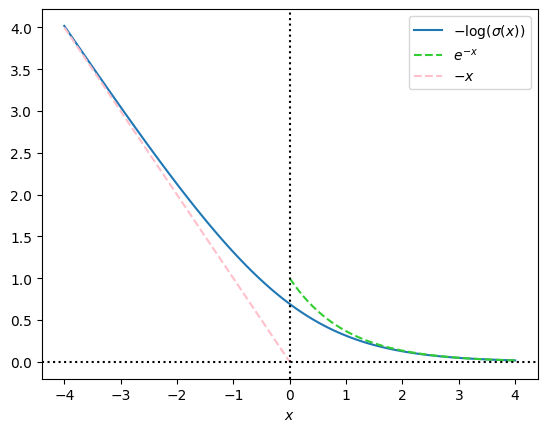

In [6]:
from matplotlib.pyplot import plot,show,xscale,yscale,imshow,legend,colorbar,hist,subplots,scatter,xlabel,ylabel,axvline,axhline
from numpy import linspace,log,exp
def plot_asymptotics(f,f_lab,f_p,f_p_lab,f_n,f_n_lab,sh=True,
                     x=linspace(-4,4,100),xp=linspace(0,4,50),xn=linspace(-4,0,50)):
  plot(x,f(x),label=f_lab)
  plot(xp,f_p(xp),color='limegreen',linestyle='dashed',label=f_p_lab)

  plot(xn,f_n(xn),color='pink',linestyle='dashed',label=f_n_lab)
  xlabel('$x$')
  axvline(c='black',linestyle='dotted')
  axhline(c='black',linestyle='dotted')
  legend()
  if sh:
    show()

phi=lambda t:-log(1/(1+exp(-t)))
phi_p=lambda x:exp(-x)
phi_n=lambda x:-x

plot_asymptotics(phi,'$-\\log(\\sigma(x))$',phi_p,'$e^{-x}$',phi_n,'$-x$')

In [7]:
cost_rats=[1,2,4,8,10,50,100]

In [23]:
from matplotlib.pyplot import plot,show,xscale,yscale,imshow,legend,colorbar,hist,subplots,scatter,title
from jax.random import split,key,bits
from time import perf_counter

from cal.rs import resamplers_list,Resampler


class NN(Module):
  features:Sequence[int]
  
  def setup(self):
    self.layers=[Dense(f) for f in self.features]
    
  def __call__(self,x):
    x=self.layers[0](x)
    for l in self.layers[1:]:
      x=l(relu(x)) # in general no restruction on float output of NN - treat as log relative likelihood
    return x

class NNPL:
  
  def __init__(self,x_train,y_train,x_test,y_test,loss,ds_name,x_dt=None,y_dt=None,rs_dir='resampled',
               bs=128,lr=1e-4,features=[128,64,32,1],seed=0,log=print,n_epochs=100):#[256,128,64,1]
    self.x_train=array(x_train,dtype=x_dt)
    if y_dt is None:
      y_dt=bool #self.x_train.dtype
    self.y_train=array(y_train,dtype=y_dt)
    self.x_test=array(x_test,dtype=x_dt)
    self.y_test=array(y_test,dtype=y_dt)
    self.p=self.y_train.mean()
    self.p_test=self.y_test.mean()
    self.bs=bs
    self.n_epochs=n_epochs
    self.lr=lr
    self.loss=loss
    self.key=key(seed)
    self.m=NN(features=features)
    self.param=self.m.init(self.getk(),self.x_train[0])
    self.g=jit(grad(lambda par,feat,targ:self.loss(self.m.apply(par,feat),targ).sum()))
    self.t=adam(learning_rate=self.lr)
    self.init_state=self.t.init(self.param)
    self.state=self.init_state
    self.log=log
    self.optimal_cutoff_indices={}
    self.ds_name=ds_name
    self.rs_dir=rs_dir

    def update(state_param,x_y):
      state,param=state_param
      x,y=x_y
      g=self.g(param,x,y)
      upd,state=self.t.update(g,state)
      param=apply_updates(param,upd)
      return (state,param),0
    
    def _updates(state_param,x_batched,y_batched):
      return scan(update,state_param,(x_batched,y_batched))[0]
    
    self._updates=jit(_updates)
    
  def updates(self,x_batched,y_batched):
    y_batched=y_batched.astype(x_batched.dtype)
    self.state,self.param=self._updates((self.state,self.param),x_batched,y_batched)

  def mk_preds(self):
    self.pred_train=self.predict_cts(self.x_train).reshape(-1)
    self.pred_test=self.predict_cts(self.x_test).reshape(-1)
    
  def fit(self,rs=''):
    t0=perf_counter()
    r=Resampler(self.x_train,self.y_train,self.rs_dir,self.ds_name,int(bits(self.getk())))
    x,y=r.get_resampled(True,rs)
    t1=perf_counter()
    if rs:self.log('Resampled in',t1-t0,'seconds')
    self.epochs(x,y)
    self.epochs_time=perf_counter()-t1
    self.log('Completed',self.n_epochs,'epochs in',self.epochs_time,'seconds')

  def epochs(self,x,y,n=None):
    if n is None:
      n=self.n_epochs
    for en in range(n):
      self.log('Running epoch',en+1,'of',n,'...',end='\r')
      x_batched,y_batched=shuffle_batched(self.getk(),x,y,self.bs)
      self.updates(x_batched,y_batched)
    self.log('Completed',n,'epochs')
    self.log('Getting fp-fn characteristic')
    self.mk_preds()
    assert self.pred_train.min()<self.pred_train.max(),\
           'Uh oh:'+str(self.pred_train.min())+'=='+str(self.pred_train.max())

    self.fp_fn_signature()

  def predict_cts(self,x):
    return self.m.apply(self.param,x)
  
  def fp_fn_signature(self):
    d_err=(1/len(self.y_train))
    self.ind_by_pred=argsort(self.pred_train)
    self.targ_by_pred=self.y_train[self.ind_by_pred]
    self.pred_sorted=self.pred_train[self.ind_by_pred]
    self.fn_rates=cumsum(self.targ_by_pred)*d_err
    self.fp_rates=flip(cumsum(flip(~self.targ_by_pred)))*d_err
    assert self.fp_rates.min()<self.fp_rates.max(),'Uh oh:'+str(self.fp_rates.min())+'=='+str(self.fp_rates.max())
    
    
    self.by_pred_test=argsort(self.pred_test)
    
    d_err_test=(1/len(self.y_test))

    self.targ_by_pred_test=self.y_test[self.by_pred_test]
    self.pred_sorted_test=self.pred_test[self.by_pred_test]
    self.fn_rates_test=cumsum(self.targ_by_pred_test)*d_err_test
    self.fp_rates_test=flip(cumsum(flip(~self.targ_by_pred_test)))*d_err_test
  
  def get_optimal_cutoff_ind(self,cost_ratio):
    return argmin(self.fp_rates+self.fn_rates*cost_ratio)
  
  def get_optimal_cutoff(self,cost_ratio):
    return self.pred_sorted[self.get_optimal_cutoff_ind(cost_ratio)]
  
  def get_bayes_cutoff(self,cost_ratio):
    return -log(cost_ratio)

  def get_bayes_cutoff_ind(self,cost_ratio):
    return argmax(self.targ_by_pred>self.get_bayes_cutoff(cost_ratio))
  
  def getk(self):
    self.key,k=split(self.key)
    return k

  def predict_bin(self,x,cost_ratio,cutoff_rule='bayes'): # NN output is relative likelihood so take log
    pred=self.predict_cts(x)
    if cutoff_rule=='bayes':
      cutoff=-log(cost_ratio)#inverse_sigmoid(cost_ratio)
    elif cutoff_rule=='optimal':
      cutoff=self.get_optimal_cutoff(cost_ratio)
      
    return pred>cutoff
  
  def fp_fn(self,cost_ratio,cutoff_rule='bayes'):
    if cutoff_rule=='optimal':
      ind_train=self.get_optimal_cutoff_ind(cost_ratio)
      ind_test=argmax(self.pred_sorted_test>self.pred_sorted[ind_train])
    elif cutoff_rule=='bayes':
      ind_train=self.get_bayes_cutoff_ind(cost_ratio)
      ind_test=argmax(self.pred_sorted_test>self.pred_sorted[ind_train])
    ret={}
    for l,ind,fpr,fnr in (('train',ind_train,self.fp_rates,self.fn_rates),
                          ('test',ind_test,self.fp_rates_test,self.fn_rates_test)):
      ret[l]={'fp':fpr[ind],'fn':fnr[ind]}
    return ret
  
  def report(self,cost_rats):
    just=14
    lj=lambda x:str(x).ljust(just)
    cutoff_rules=['bayes','optimal']
    self.log('cost_rat'.ljust(just)+(''.join([(lj('fp_'+s))+(lj('fn_'+s)) for s in cutoff_rules]))+\
             lj('fp_test')+lj('fn_test')+lj('E_test(cost)'))
    for cost_ratio in cost_rats:
      s=lj(str(cost_ratio))
      for cutoff_rule in cutoff_rules:
        res=self.fp_fn(cost_ratio,cutoff_rule=cutoff_rule)
        s+=lj(res['train']['fp'])+lj(res['train']['fn'])
      s+=lj(res['test']['fp'])+lj(res['test']['fn'])
      s+=lj((res['test']['fp']+res['test']['fn']*cost_ratio)/(1+cost_ratio))
      print(s)
  
  def plot(self,ttl):
    show()
    plot(self.fp_rates,self.fn_rates)
    plot([self.fp_rates[0],self.fp_rates[-1]],[self.fn_rates[0],self.fn_rates[-1]])
    title(ttl)
    xlabel('False positives')
    ylabel('False negatives')
    show()


## Experiment 0
### Experiment 0.1: BCE on raw data
- Here we train with BCE and measure performance against a range of possible cost ratios
- Want to test effects of common resampling techniques

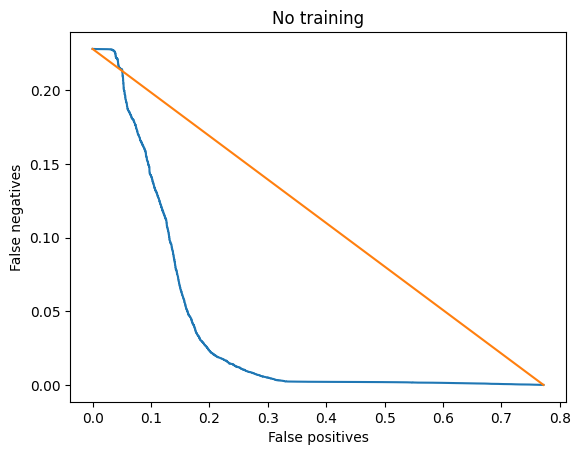

In [24]:
nnpl=NNPL(x_train,y_train,x_test,y_test,sigmoid_binary_cross_entropy,'unsw')

nnpl.mk_preds()
nnpl.fp_fn_signature()
nnpl.plot('No training')

Completed 100 epochs 100 ...
Getting fp-fn characteristic
Completed 100 epochs in 11.47765067499131 seconds
Not well calibrated (Bayes rule for threshold is useless) but not a problem really
cost_rat      fp_bayes      fn_bayes      fp_optimal    fn_optimal    fp_test       fn_test       E_test(cost)  
1             0.7718331     5.7031725e-06 0.028487347   0.0059427056  0.020818152   0.03876986    0.05958801    
2             0.77187306    0.0           0.028880866   0.0056119217  0.021534763   0.035526894   0.09258855    
4             0.77187306    0.0           0.029000632   0.005560593   0.021668367   0.034373026   0.15916047    
8             0.77187306    0.0           0.033061292   0.0048020715  0.025992325   0.01995579    0.18563864    
10            0.77187306    0.0           0.033061292   0.0048020715  0.025992325   0.01995579    0.22555022    
50            0.77187306    0.0           0.037749298   0.0046195695  0.031628042   0.01252247    0.65775156    
100           0.77

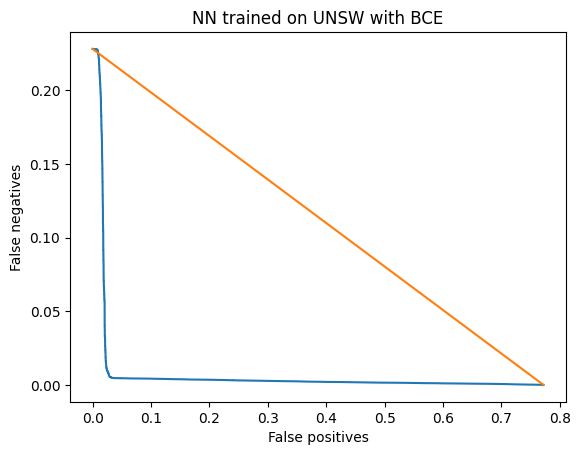

In [25]:
nnpl.fit()
print('Not well calibrated (Bayes rule for threshold is useless) but not a problem really')
nnpl.report(cost_rats)
nnpl.plot('NN trained on UNSW with BCE')

### Experiment 0.2: Effects of resampling schemes on BCE
$\newcommand\rs{\texttt{rs}}$
- Common to try using various resampling schemes during training
- Such a scheme takes dataset $D=(x^{(i)},y^{(i)})$ and transforms it to $D_\rs=(x_\rs^{(i)},y_\rs^{(i)})$
- Idea: address issues that arise from imbalance (note this framing is contentious in literature, with some taking a view that particularly hard problems described in this way may be better understood as a problem of limited data)

In [26]:
print(resamplers_list)

['NearMiss', 'SMOTEENN', 'ADASYN', 'SMOTE', 'SMOTETomek', '']


In [ ]:
nns={}
for rs in resamplers_list:
  nn=NNPL(x_train,y_train,x_test,y_test,sigmoid_binary_cross_entropy,'unsw')
  nn.fit(rs=rs)
  nnpl.report(cost_rats)
  nns[rs]=nn

#### Cost loss?
- Probablistically BCE loss analogous to learning likelihoods over wide range - use cases include high uncertainty in future costs
- Fixing costs is in a sense at other extreme of possible approaches - all we care about is whether likelihoods are above a set threshold
- Costs $\chi_\pm$ for false negatives and false positives have an associated loss with constant gradient with respect to $\tilde y$ for fixed $y'\in\{\pm\}$,
$$
C_\chi(\tilde y,y)=\chi_+1_{y=+}(1-\tilde y)+\chi_-1_{y=-}\tilde y
$$
so that gradients in the direction of the correct label are scaled by some notion of importance of each class.
When reframed as a function of the density this becomes
$$
\widetilde C_\chi(\rho,y)=\chi_+1_{y=+}\sigma(-\rho)+\chi_-1_{y=-}\sigma(\rho)
$$

### Experiment 0.2: Cost

In [ ]:
def mk_cost(cr):
  def cost(pred,targ):
    pred=sigmoid(pred)
    return (cr*targ*(1-pred)+(1-targ)*pred)
  return jit(cost)

print('Training on cost...')
for cr in cost_rats+[200,400]:
  nn=NNPL(x_train,y_train,x_test,y_test,mk_cost(cr))
  nn.epochs()
  nn.report(cost_rats)
  nn.plot('NN trained on UNSW with cost for ratio '+str(cr))

# General classifier losses as weighted sums of costs
- At a glance seems cost may be useless - but any loss of interest can be written as a sum of all possible costs



## Expected misclassification cost 
In a random formulation eg per https://link.springer.com/article/10.1007/s10994-024-06634-8 we seek to minimise $c$ in expectation:
$\newcommand\dee{\mathrm{d}}$
$$
\mathbb E(c)=\int_{\Sigma\times\mathcal X\times\mathcal Y} C_\sigma(y',\hat y_{\sigma'}(x'))\dee\mathbb P(\sigma',x',y')
$$
Try their losses - but might be the case that most important aspect of analysis is asymptotic behaviour of losses


### Beta losses

- Authors let positive and negative costs be gamma RVs with parameters $(\alpha,\theta)$ and and obtain an expected misclassification cost proportional to
\begin{align*}
L_{\alpha\beta}(\tilde y,y)=&\int_0^{\tilde y}(t-y)t^{\alpha-1}(1-t)^{\beta-1}\dee t\\
=&\begin{cases} -\int_0^{\tilde y}t^{\alpha-1}(1-t)^\beta\dee t\text{ if }y=+,\\
\int_0^{\tilde y}t^\alpha(1-t)^{\beta-1}\dee t\text{ otherwise}\end{cases}\\
=&B(\alpha+(1-y),\beta+y;\tilde y)\\
=&B(a,b,\tilde y)\text{ for convenience}
\end{align*}
- $B$ is well known - the (incomplete) beta function 


### Loss asymptotics II: Beta loss at high certainties
- $a$ and $b$ describe the asymptotic order of $B(a,b,t)$ for $t\approx0$ and $t\approx 1$ respectively
- Specifically can check that
$$
B(a,b,t)\sim\begin{cases}O\left(\begin{cases}t^a\text{ if }a>0\\\log(t)\text{ if }a=0\end{cases}\right)\text{ when }0\approx t\ll1,\\O\left(\begin{cases}(1-t)^b\text{ if }b>0\\\log(1-t)\text{ if }b=0\end{cases}\right)\text{ when }0\ll t\approx1\end{cases}
$$


- This behaviour is mirrored in the log likelihood picture, where
$$
\widetilde B(a,b,\rho)\sim\begin{cases}
O\left(\begin{cases}
e^{\rho a}\text{ if }a>0\\
\rho\text{ if }a=0
\end{cases}\right)\text{ when }\rho\ll0,\\
O\left(\begin{cases}
e^{-\rho b}\text{ if }b>0\\
-\rho\text{ if }b=0
\end{cases}\right)\text{ when }\rho\gg0
\end{cases}
$$

- which means that
$$
\widetilde L_{\alpha\beta}(\rho,+)=\tilde B(\alpha,\beta+1;\rho)\sim
\begin{cases}
O(-e^{\rho\alpha})\text{ if }\alpha>0,~y=+\text{ and }\rho\ll0\\
O(-\rho)\text{ if }\alpha=0,~y=+\text{ and }\rho\ll0\\
O(e^{\rho(\beta+1)})\text{ if }~y=+\text{ and }\rho\gg0\\
\end{cases}
$$

- The parameters $\alpha$ and $\beta$ are not directly related to any single value of cost and should be taken to describe the tail risk associated with each type of error
- This is in line with the consequences of different decisions eg in the case of cybersecurity - legitimate traffic on a network being blocked may cause serious problems in the short term, but doesn't typically have the risks associated with malicious actors being able to access a network.

### Loss asymptotics III: Beta loss for small $\alpha$ and $\beta$ as perturbations of BCE
- From above discussion view $\alpha$ and $\beta$ as controlling the cost uncertainty for false 
- Need each of $\alpha'$ and $\beta'$ in the above expression to be nonnegative, whence it is necessary that $(\alpha,\beta)\in[0,\infty)^2$
- Can check by substitution that $B(a,b;c)=B(b,a,1-c)$ and $B(-1,0;\tilde y)=\log\tilde y$
- It follows that $L_{00}=\SBCE$
- If $\alpha$ and $\beta$ are small this is a parameterised perturbation of the BCE - in order for the loss to be well defined both $\alpha$ and $\beta$ must be nonnegative so the BCE can be seen is a limit as uncertainty in the positive and negative costs diverges

In [ ]:
from jax.scipy.special import betainc
def mk_beta(alpha,beta):
  def b(t):
    return betainc(alpha,beta,sigmoid(t))
  return jit(b)

alphas_betas=[(a,b) for a in linspace(0,1,6) for b in linspace(a+1,a+3,4)]

Ir=linspace(-4,4,50)
for a,b in alphas_betas:
  plot(Ir,mk_beta(a,b)(Ir))
title('Beta losses as a function of predicted likelihood for y=+')
show()

Ip=linspace(0,1,50)
for a,b in alphas_betas:
  plot(Ip,betainc(a,b,Ip))
title('Beta losses as a function of predicted probability for y=+')
show()

def mk_beta_loss(alpha,beta)):
  bet_pos=mk_beta(alpha,beta)
  def beta_loss(pred,targ):
    


### Loss asymptotics III: $\alpha$ versus $\beta$

\begin{align*}
\widetilde L_{\alpha\beta}(\rho,y)=&\int_{-\infty}^\rho(\sigma(r)-y)(\sigma(r)^{\alpha+1})(1-\sigma(r))^{\beta-1}e^{-r}\dee r\\
=&\int_{-\rho}^\infty((1-\sigma(r))-y)((1-\sigma(r))^{\alpha-1})(\sigma(r))^{\beta+1}e^{r}\dee r\\
\end{align*}



### Loss asymptotics III: General Beta losses
Rewriting the loss in terms of relative likelihood we get


In [ ]:
def sample_expected_loss(targ,pred,)

In [ ]:
!ls

In [ ]:
!ls cal

In [ ]:
print(y_train.shape)

In [ ]:
print(y_train.dtype)

In [ ]:
y_train[:10]

In [ ]:
def binarise(x,red=None):#not ery efficient ofh well
  b=array([[i for i in _x.tobytes()] for _x in x],dtype=bool)
  red=b.max(axis=0)!=b.min(axis=0) if red is None else red
  print(red)
  return {'x':b[:,red],'mask':red}



In [ ]:

#binarise train and test data - possibly silly?
Y={'generic_train':generic_train,'generic_test':generic_test}
X_train={'orig':{'x':x_train_orig},'norm':{'x':x_train_norm}}
X_test={'orig':{'x':x_test_orig},'norm':{'x':x_test_norm}}
redundant_dims={}
[(X_train.update({lab+'_bin':a}),redundant_dims.update({lab:b})) for lab,(a,b) in\
 [(lab,binarise(x['x'])) for (lab,x) in X_train.items()]]
                
[print(x['x'].shape) for k,x in X_train.items()]

In [ ]:

[X_test.update({lab+'_bin':binarise(x['x'],red=redundant_dims[lab])}) for (lab,x) in X_test.items()]

In [ ]:
[print(k,v['x'].shape) for k,v in X_train.items()]

In [ ]:
def get_dat(x,y):
  r={}
  y=y.reshape(-1,1)

  r['fp']=(x&~y).mean(axis=0)
  r['fn']=((~x)&y).mean(axis=0)
  print(x.shape)
  r['dim_universe']=sum(x.max(axis=0)!=x.min(axis=0))
  r['avg']=x.mean(axis=0)

  return r
  
def plot_dat(d,l):
  subplots()
  print(l,':')
  if l=='fpfn':
    scatter(d['fp'],d['fn'])
  else:
    hist(d[l])
  

In [ ]:

print(generic_train.shape)
print(generic_test.mean())


In [ ]:
dat_bin_orig=get_dat(X_train['orig_bin']['x'],generic_train)
dat_bin_normalised=get_dat(X_train['norm_bin']['x'],generic_train)


print('Ambient dimension of original:',dat_bin_orig['dim_universe'])

print('Ambient dimension after mu,sigma=0,1 rescaling:',dat_bin_normalised['dim_universe'])

In [ ]:
print('Original:')
plot_dat(dat_bin_orig,'fp')
plot_dat(dat_bin_orig,'fn')
plot_dat(dat_bin_orig,'fpfn')
print(dat_bin_normalised['fn'])
#xscale('log')
#yscale('log')

In [ ]:
res={}
for l,xd in X_train.items():
  x=xd['x']
  
  m=RandomForestRegressor(n_jobs=-1)
  m.fit(x,generic_train)
  
  res[l]=m





In [ ]:
print(list(res))

In [ ]:
def fp_fn(mod,x,y,thresh):
  yp=mod.predict(x)>thresh
  return {'fp':(yp&(~y)).mean(),'fn':((~yp)&y).mean()}

In [ ]:
[print(l,*fp_fn(res[l],v['x'],generic_train,.5).items()) for l,v in X_train.items()]

In [ ]:
[print(l,*fp_fn(res[l],v['x'],generic_test,.5).items()) for l,v in X_test.items()]

In [ ]:
print(*fp_fn(res['orig']['bin'],x_binary_orig,generic,.5).items())

In [ ]:
print(*fp_fn(res['normalised']['bin'],x_binary_normalised,generic,.5).items())